In [1]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [2]:
include(joinpath(@__DIR__, "..", "hrm_common.jl"))

testo (generic function with 1 method)

In [3]:
using Plots, Test

In [38]:
#data generator
# y = w^T x + 0.1 * ||x||^2 + eps, where ( eps is N(0, 0.01) )

struct ToyGen
    w::Vector{Float32}
end

function ToyGen(d_in::Int; seed::Int=123)
    Random.seed!(seed)
    w = randn(Float32, d_in)
    return ToyGen(w)
end

#returns (x, y) with shapes (d_in, batch), (1, batch)
function sample!(gen::ToyGen, batch::Int)
    d = length(gen.w)
    x = randn(Float32, d, batch)
    # linear part
    y_lin = gen.w' * x      # (1, batch)
    # small quadratic interaction
    y_quad = 0.1f0 .* sum(abs2, x; dims=1)    # (1, batch)
    # noise
    eps = 0.01f0 .* randn(Float32, 1, batch)
    y = Float32.(y_lin .+ y_quad .+ eps)
    return x, y
end

sample! (generic function with 1 method)

In [39]:
CFG = (
    num_tokens = 128, # vocabulary size per feature
    d_embed    = 32,   # embedding width per feature

    d_in   = 16,     # input features
    d_hid  = 64,     # hidden/state size (L and H)
    d_out  = 1,      # output size
    N      = 2,      # high-level cycles per segment
    T      = 3,      # low-level steps per H cycle
    M      = 1,      # segments per batch
    batch  = 64,     # batch size
    lr     = 1e-3,   # learning rate
    steps  = 300,    # training steps
    seed   = 42      # RNG seed
)

Random.seed!(42)

TaskLocalRNG()

In [41]:
"""
    quantize_to_tokens(x; num_tokens::Int, lo::Real, hi::Real)

Uniformly bins each element of x in [lo, hi] into 1..num_tokens.
Clamps values outside [lo, hi] to the nearest edge bin.
"""
LO = -3.0
HI =  3.0

function quantize_to_tokens(x; num_tokens::Int, lo::Real, hi::Real)
    @assert num_tokens >= 2
    # normalize to [0,1]
    xn = @. clamp((x - lo) / (hi - lo + eps(eltype(x))), 0, 1)
    # map to 0..num_tokens-1, then shift to 1..num_tokens
    ids = floor.(Int, xn .* (num_tokens - 1)) .+ 1
    return ids
end

quantize_to_tokens (generic function with 1 method)

In [32]:
function build_models(cfg)
    d_in, d_hid, d_out = cfg.d_in, cfg.d_hid, cfg.d_out
    num_tokens, d_embed = cfg.num_tokens, cfg.d_embed

    # per-feature token embedding, then pool features, then project to d_hid
    fI = Lux.Chain(
        Lux.Embedding(num_tokens, d_embed, Lux.glorot_uniform), # or Lux.glorot_normal
        # pool over the feature axis (2nd dim) -> (d_embed, batch)
        x -> dropdims(mean(x; dims=2), dims=2),
        Lux.Dense(d_embed => d_hid, NNlib.gelu)
    )

    # projections used inside fL/fH
    proj_task = Lux.Chain(Lux.Dense(d_hid => d_hid))
    proj_high = Lux.Chain(Lux.Dense(d_hid => d_hid))
    proj_low  = Lux.Chain(Lux.Dense(d_hid => d_hid))

    # MLP "cells" (unchanged)
    fL_cell = Lux.Chain(
        Lux.LayerNorm(d_hid),
        Lux.Dense(d_hid => 4d_hid, NNlib.gelu),
        Lux.Dense(4d_hid => d_hid)
    )
    fH_cell = Lux.Chain(
        Lux.LayerNorm(d_hid),
        Lux.Dense(d_hid => 4d_hid, NNlib.gelu),
        Lux.Dense(4d_hid => d_hid)
    )

    fO = Lux.Chain(Lux.Dense(d_hid => d_out))

    return (; fI, proj_task, proj_high, proj_low, fL_cell, fH_cell, fO)
end


build_models (generic function with 1 method)

In [33]:

function setup_params_states(models)
    rng = Random.default_rng()
    psI,  stI  = Lux.setup(rng, models.fI)
    psPT, stPT = Lux.setup(rng, models.proj_task)
    psPH, stPH = Lux.setup(rng, models.proj_high)
    psPL, stPL = Lux.setup(rng, models.proj_low)
    psLc, stLc = Lux.setup(rng, models.fL_cell)
    psHc, stHc = Lux.setup(rng, models.fH_cell)
    psO,  stO  = Lux.setup(rng, models.fO)

    ps = (I=psI, PT=psPT, PH=psPH, PL=psPL, Lc=psLc, Hc=psHc, O=psO)
    st = (I=stI, PT=stPT, PH=stPH, PL=stPL, Lc=stLc, Hc=stHc, O=stO)
    return ps, st
end

setup_params_states (generic function with 1 method)

In [34]:
loss_fn(yhat, y) = mean(abs2, yhat .- y)

function init_states(batch::Int, d::Int)
    return (zeros(Float32, d, batch), zeros(Float32, d, batch))  # (low, high)
end

init_states (generic function with 1 method)

In [35]:
function run_segment!(models, ps, st, x, low_state, high_state; N::Int, T::Int)
    # task embedding from input
    e_task, stI = Lux.apply(models.fI, x, ps.I, st.I)

    stPT, stPH, stPL, stLc, stHc = st.PT, st.PH, st.PL, st.Lc, st.Hc

    for k in 1:N
        # low-level T steps
        for t in 1:T
            et,  stPT = Lux.apply(models.proj_task, e_task,      ps.PT, stPT)
            hh,  stPH = Lux.apply(models.proj_high, high_state,  ps.PH, stPH)
            xL = low_state .+ et .+ hh
            yL, stLc = Lux.apply(models.fL_cell, xL, ps.Lc, stLc)
            low_state = xL .+ yL
        end
        # one high-level step
        ll,  stPL = Lux.apply(models.proj_low, low_state, ps.PL, stPL)
        xH = high_state .+ ll
        yH, stHc = Lux.apply(models.fH_cell, xH, ps.Hc, stHc)
        high_state = xH .+ yH
    end

    yhat, stO = Lux.apply(models.fO, high_state, ps.O, st.O)
    st_new = (I=stI, PT=stPT, PH=stPH, PL=stPL, Lc=stLc, Hc=stHc, O=stO)
    return yhat, st_new, low_state, high_state
end

run_segment! (generic function with 1 method)

In [36]:
function train_step!(models, ps, st, opt, gen, cfg)
    # batch from generator (floats)
    x, y = sample!(gen, cfg.batch)

    # NEW: quantize floats → integer token IDs
    x_ids = quantize_to_tokens(x; num_tokens=cfg.num_tokens, lo=LO, hi=HI)

    # recurrent states
    low_state, high_state = init_states(cfg.batch, cfg.d_hid)

    total_loss = 0.0f0

    for m in 1:cfg.M
        function seg_loss(ps_local)
            # pass x_ids instead of x
            yhat, st_new, low_new, high_new =
                run_segment!(models, ps_local, st, x_ids, low_state, high_state; N=cfg.N, T=cfg.T)
            L = loss_fn(yhat, y)
            return L, (st_new, low_new, high_new)
        end

        (L, (st_new, low_new, high_new)), back = Zygote.pullback(seg_loss, ps)
        grads = back((one(L), nothing))[1]
        opt, ps = Optimisers.update(opt, ps, grads)
        st = st_new
        total_loss += L

        low_state  = Zygote.dropgrad(low_new)
        high_state = Zygote.dropgrad(high_new)
    end

    return total_loss, ps, st, opt
end

train_step! (generic function with 1 method)

In [42]:
models = build_models(CFG)
ps, st  = setup_params_states(models)
opt     = Optimisers.setup(Optimisers.Adam(CFG.lr), ps)
gen     = ToyGen(CFG.d_in; seed=421)

loss_hist = Float32[]
for step in 1:CFG.steps
    L, ps, st, opt = train_step!(models, ps, st, opt, gen, CFG)
    push!(loss_hist, L)
    if step % 25 == 0
        @info "step=$(step) loss=$(round(L; digits=4))"
    end
end

┌ Info: step=25 loss=16.7863
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/02_semi_canonical/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:11
┌ Info: step=50 loss=16.9428
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/02_semi_canonical/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:11
┌ Info: step=75 loss=13.4779
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/02_semi_canonical/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:11
┌ Info: step=100 loss=15.5021
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/02_semi_canonical/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:11
┌ Info: step=125 loss=12.8922
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/02_semi_canonical/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:11
┌ Info: step=150 loss=19.7489
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/02_semi_canonical/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W

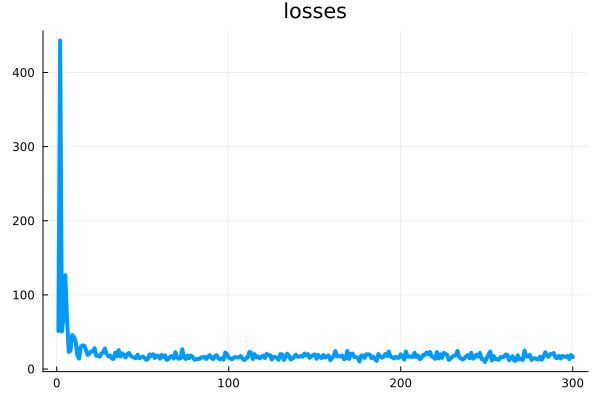

In [43]:
p = plot(loss_hist, title="losses", linewidth=4, legend=false)
savefig(p,"figures/losses.png")
display(p)